Ce code a pour objectif de détecter les zones de cyclogenèse ainsi que les trajectoires de celle-ci à l'aide des données du modèle IFS.
Dans un premier temps, on va expliquer le code permettant d'obtenir les clusters des cyclogenèses, puis le code expliquant les clusters de trajectoires.

# On importe les librairies

In [205]:
                               #################IMPORTATION LIBRAIRIES####################

import pandas as pd
import datetime
from datetime import date,datetime, timedelta
import numpy as np
import seaborn as sns 
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix
import time
import math
from scipy.optimize import curve_fit
from dateutil import parser
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from termcolor import colored
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import alphashape
from descartes import PolygonPatch #Permet de tracer l'enveloppe

#######On importe les trajectoires vraies qui vont nous permettre de les tracer
os.chdir('C:/Users/etulyon1/Desktop/Stage M1/Data/francetransfert-1800090517/classification_TC_scenarii/')
traj_Ana = pd.read_csv('traj_Ana.csv', sep = ';', usecols = ['date_point', 'lat', 'lon'])
traj_Batsirai = pd.read_csv('traj_Batsirai.csv', sep = ';', usecols = ['date_point', 'lat', 'lon'])
traj_Cliff = pd.read_csv('traj_Cliff.csv', sep = ';', usecols = ['date_point', 'lat', 'lon'])
traj_Dumako = pd.read_csv('traj_Dumako.csv', sep = ';', usecols = ['date_point', 'lat', 'lon'])
traj_Emnati = pd.read_csv('traj_Emnati.csv', sep = ';', usecols = ['date_point', 'lat', 'lon'])

# Fonctions

In [206]:
# fonction de remplacement des séparateurs '*' par des séparateur ' '
def format_sin_file(file_name):
    #file_name = 'sin'
    #read input file
    fin = open(file_name, "rt")
    #read file contents to string
    data = fin.read()
    #replace all occurrences of the required string
    data = data.replace('*', ' ')
    #close the input file
    fin.close()
    #open the input file in write mode
    fin = open(file_name, "wt")
    #overrite the input file with the resulting data
    fin.write(data)
    #close the file
    fin.close()
    
    
    
# fonction de création de fichiers contenant la trajectoire de chaque système (DT, TS ou CT) prévu par un membre à partir du fichier sin (formaté) disponible pour chaque membre de la prévision d'ensemble,
# i.e si un membre prévoit 4 systèmes, 4 fichiers séparés vont être créés  
def create_traj_files(file_name, member_number, nb_TC_in_member):
    key_words = ['SNBR']

    #read input file
    input_file = open(file_name, "rt")

    TC_number = 0
    for line in input_file:
        if any(key_word in line for key_word in key_words):
            if (TC_number !=0):
                #fermeture du fichier en cours d'écriture
                output_file.close()
            #ouverture d'un nouveau fichier pour écrire une track
            TC_number = TC_number + 1
            new_file_name = 'sin_TC_' + str(member_number).zfill(2) + '_' + str(TC_number).zfill(2) 
            output_file = open(new_file_name, "wt")
        else:
            if (TC_number > 0):
                output_file.write(line)
    output_file.close()
    
    nb_TC_in_member[str(member_number).zfill(3)] = TC_number

    
#fonction qui ouvre un fichier de trajectoire d'un membre et retourne les features calculées de ce membre
def extract_features_from_TC_file(file_name, run_date):
    df = pd.read_fwf(file_name, sep=' ', header=None) #fwf fonctionne avec les fichiers de données dont les largeurs de colonnes sont connues et fixes
    df.columns = ['INDEX', 'DATE', 'LAT', 'LON', 'VMAX', 'PMIN', 'NA1','NA2','NA3','NA4','NA5']
    df = df.drop(['INDEX','NA1', 'NA2', 'NA3', 'NA4','NA5'], axis=1)  #supprimer les colonnes inutiles
    df = df.iloc[:-1 , :]   #supprimer la dernière ligne qui ne contient pas de données de trajectoire
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    #print(df)
    #print('\n')
    
    ###########  calcul des features du TC  ###################################################
    ####  L'ajout de nouveaux features à calculer se fera ci-dessous                       ####
    ###########################################################################################
    
    TC_start_date = df.iloc[0,0] # Il prend la ligne 0 et prend la valeur 0 in fine la première valeur.
    TC_end_date = df.iloc[-1,0] # Il prend la dernière ligne et prend la valeur 0 in fine la première valeur.
    
    TC_start_lat = df.iloc[0,1]/10 
    TC_start_lon = df.iloc[0,2]/10
    
    
    TC_duration = TC_end_date - TC_start_date
    TC_duration = TC_duration.days  #durée de vie exprimée en jours 
    
    #conversion de la date de début de TC en durée (en jours) depuis l'échéance 0 du run
    TC_start_date = TC_start_date.to_pydatetime()
    TC_start_date = TC_start_date - run_date
    TC_start_date = TC_start_date.days
    
    #min Pmin
    TC_min_PMIN = df['PMIN'].min()
    #max Vmax
    TC_max_VMAX = df['VMAX'].max()
    
    return TC_start_date, TC_start_lat, TC_start_lon, TC_duration, TC_min_PMIN, TC_max_VMAX 

def extract_traj_from_TC_file(file_name, run_date):
    df = pd.read_fwf(file_name, sep=' ', header=None)
    df.columns = ['INDEX', 'DATE', 'LAT', 'LON', 'VMAX', 'PMIN', 'NA1','NA2','NA3','NA4','NA5']
    df = df.drop(['INDEX','NA1', 'NA2', 'NA3', 'NA4','NA5'], axis=1)  #supprimer les colonnes inutiles
    df = df.iloc[:-1 , :]   #supprimer la dernière ligne qui ne contient pas de données de trajectoire
    
    LAT = - df['LAT'].to_numpy()/10
    LON = df['LON'].to_numpy()/10
    temps = []
    for duree_ in range(len(df)):  #Cette boucle permet de créer une colonne DUREE dans laquelle on va avoir un float du temps nous permettant de tracer lat=f(t) et lon=f(t)
        nb_jour = parser.parse(df['DATE'][duree_]) - run_date # On calcule la diff de temps entre l'observation et le run_date
        temps.append(nb_jour.total_seconds()/(60 * 60 * 24)) #On transforme notre datetime en float
    df['DUREE'] = temps #On crée la colonne durée dans notre df
    
    DUREE = df['DUREE'].to_numpy()
    
    return LAT, LON, DUREE

#Fonction permettant de corréler l'épaisseur d'un cadre au nombre de membres qui prédisent une cyclogenèse
def epaisseur(point):
    if point <= 5 :
        return 0.5
    elif point > 5 and point < 10:
        return 1.3
    elif point >= 10 and point < 15:
        return 2.5
    elif point >= 15 and point < 20:
        return 3.7
    elif point >= 20 and point < 25:
        return 4.9
    elif point >= 25 and point < 30:
        return 6.1
    elif point >= 30 and point < 35:
        return 7.3
    elif point >= 35 and point < 40:
        return 8.5
    elif point >= 40 and point < 45:
        return 9.7
    elif point >= 45 :
        return 10.9   

#Fonction permettant calculer la distance entre les points lorsque l'on trace l'enveloppe.
def distance(origin, destination):
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d
   

# Choix date/Filtrage

CHOIX DATE DE NOTRE CHOIX 

In [207]:
#Choisir un mois parmi m = 1 ou m = 2 ; 1 = janvier ; 2 = février
m = 2  
#Choisir un jour parmi j = [10 , 17 , 24 , 31] pour m = 1 et j = [ 7 ] pour m = 2
j= 7    

In [208]:
print(colored(f'PREVISION DU {j}/0{m}/2022 \n', attrs=['bold']))
run_date = datetime(2022, m, j)
########################################################
n_clusters = 3
nb_members = 51
run_dir= str(run_date.year) + str(run_date.month).zfill(2) + str(run_date.day).zfill(2) #le zfill permet de rajouter un 0 au str
nb_TC_in_member=dict()  
cluster_color_list=['b','g','r','c','m','y','b']

for member_number in range(0,nb_members + 1):
    os.chdir('C:/Users/etulyon1/Desktop/Stage M1/Data/francetransfert-1800090517/classification_TC_scenarii/' + run_dir + '/' + str(member_number).zfill(3))
    format_sin_file('sin')
    create_traj_files('sin',member_number,nb_TC_in_member)

df_ens = pd.DataFrame(columns = ['member_number', 'TC_number_in_member', 'TC_start_date', 'TC_start_lat', 'TC_start_lon', 'TC_duration', 'TC_min_PMIN', 'TC_max_VMAX' ]) 
index = 0

for member_number in range(0,nb_members + 1):
    member_number_dir = str(member_number).zfill(3)
    os.chdir('C:/Users/etulyon1/Desktop/Stage M1/Data/francetransfert-1800090517/classification_TC_scenarii/' + run_dir + '/' + member_number_dir)
    #print('member_number=' + str(member_number))
    for TC_number in range(1, nb_TC_in_member[member_number_dir]+ 1):
        #print('TC_number=' + str(TC_number))
        file_name= 'sin_TC_'  + str(member_number).zfill(2) + '_' + str(TC_number).zfill(2)
        TC_start_date, TC_start_lat, TC_start_lon, TC_duration, TC_min_PMIN, TC_max_VMAX = extract_features_from_TC_file(file_name, run_date)
        df_ens.loc[index]=[ member_number, TC_number, TC_start_date, TC_start_lat, TC_start_lon, TC_duration, TC_min_PMIN, TC_max_VMAX ]
        index = index + 1

PREVISION DU 7/02/2022 



CHOIX DES FILTRES

In [209]:
#4 semaines de prévisions à partir de la date affichée.
#suppression des sytèmes dont la durée de vie est inférieure à 4 jours
df_ens_filtered = df_ens[df_ens['TC_duration'] > 5 ] 
#suppresion des système ayant déja démarré. Cyclogenèse donc TC_Start_Date =/= 0 
df_ens_filtered = df_ens_filtered[df_ens_filtered['TC_start_date'] >1] 
#suppresion des système démarrant au delà de 15 jours.
df_ens_filtered = df_ens_filtered[df_ens_filtered['TC_start_date'] <15] 

CHOIX DES FEATURES

In [210]:
feature_list = ['TC_start_date','TC_start_lat', 'TC_start_lon', 'TC_duration'] 

ON NORMALISE

In [211]:
n_features = len(feature_list)
X = df_ens_filtered[feature_list].to_numpy()
X = StandardScaler().fit_transform(X)

# Classification cylogenèse

## Modèle de clustering DB_Scan

In [212]:
#DBSCAN
db = DBSCAN(eps=0.9, min_samples=5).fit(X)   #eps et min_samples sont les hyperparamètres

#On enregistrer les valeurs du modèle dans notre dataFrame 
df_ens_filtered['Label_DB_SCAN'] = db.labels_

## Création de dictionnaires

Étape essentielle pour pouvoir avoir les différentes informations sur les cartes (Date de cyclogenèse, cadre de zone d'apparition etc)

In [213]:
#Création d'un dictionnaire qui permet d'afficher les moyennes des différentes features
centroids= dict()
cluster_method_name ='DB_SCAN'
centroids_tmp = np.empty([n_clusters,n_features +1]) #[nb_lignes, nb_colonnes] #On rajoute une colonne pour ajouter le nombre de points que l'on comptabilise
df_ens_filtered['Label_DB_SCAN'] = df_ens_filtered['Label_DB_SCAN'].replace(to_replace = -1, value = np.nan)
df_ens_filtered_db_scan = df_ens_filtered.dropna(axis = 0)
for cluster in range(0, n_clusters):
    df_cluster = df_ens_filtered_db_scan[df_ens_filtered_db_scan['Label_' + cluster_method_name] == cluster]
    #calcul des features du centroide du label
    for feature in range(0,n_features+1):
        if feature == n_features : #Ce if permet de compter le nombre de points de la même couleur sur les graphes
            centroids_tmp[cluster,feature] = int(len(df_ens_filtered_db_scan[df_ens_filtered_db_scan['Label_' + cluster_method_name] == cluster]))-1 #Si on fait pas le -1 en comptant on en a un en trop
        else :
            centroids_tmp[cluster,feature] = df_cluster[feature_list[feature]].mean()
centroids[cluster_method_name] = centroids_tmp

#Création d'un dictionnaire qui permet d'afficher les écart-type des des différentes features
centroids_std= dict()
centroids_tmp_std = np.empty([n_clusters,n_features])
df_ens_filtered['Label_DB_SCAN'] = df_ens_filtered['Label_DB_SCAN'].replace(to_replace = -1, value = np.nan)
df_ens_filtered_db_scan = df_ens_filtered.dropna(axis = 0)
for cluster_std in range(0, n_clusters):
    df_cluster_std = df_ens_filtered_db_scan[df_ens_filtered_db_scan['Label_' + cluster_method_name] == cluster_std]
    #calcul des features du centroide du label
    for feature_std in range(0,n_features):
        centroids_tmp_std[cluster_std,feature_std] = df_cluster_std[feature_list[feature_std]].std()
centroids_std[cluster_method_name] = centroids_tmp_std

## On enregistre les valeurs des dictionnaires dans des listes

In [214]:
#Permet d'afficher les dates d'apparitions des cyclones dans les prévisions (format décimale)
date =[]
latitude = []
longitude = []
nb_points = []
date_std = []
latitude_std = []
longitude_std = []

key = 'Label_DB_SCAN'
for ajout in range(len(centroids['DB_SCAN'])): #Faire attention à ce que les valeurs correspondent bien à l'ordre dans les n_features
    date.append(centroids['DB_SCAN'][ajout][0])
    latitude.append(centroids['DB_SCAN'][ajout][1])
    longitude.append(centroids['DB_SCAN'][ajout][2])
    nb_points.append(centroids['DB_SCAN'][ajout][len(feature_list)])  #De cette manière il prend la dernière valeur de la feature list +1

for ajout_std in range(len(centroids_std['DB_SCAN'])): #Faire attention à ce que les valeurs correspondent bien à l'ordre dans les n_features
    date_std.append(centroids_std['DB_SCAN'][ajout_std][0])
    latitude_std.append(centroids_std['DB_SCAN'][ajout_std][1])
    longitude_std.append(centroids_std['DB_SCAN'][ajout_std][2])

nb_points = np.around(nb_points, decimals = 0)
date_std = np.around(date_std, decimals = 0)

####POUR DATE
##On convertit nos dates en date datetime
date_bis = []
for date_b in date:
    if math.isnan(date_b):
        continue
    else :
        date_b = round(date_b)
        a = run_date + timedelta(days = date_b)
        date_bis.append(a)

##On convertit nos dates datetime juste en jour et en mois pour l'affichage sur les cartes
jour_apparition = []
mois_apparition = []
for date_appari in date_bis:
    jour_apparition.append(date_appari.day)
    mois_apparition.append(date_appari.month)

## On affiche la carte de prédiction de cyclogenèse

Pour la colonne du Label_DB_SCAN


<ipython-input-215-b1a5e5b9159e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ens_filtered_db_scan['Label_DB_SCAN'] = df_ens_filtered_db_scan['Label_DB_SCAN'].astype(int)


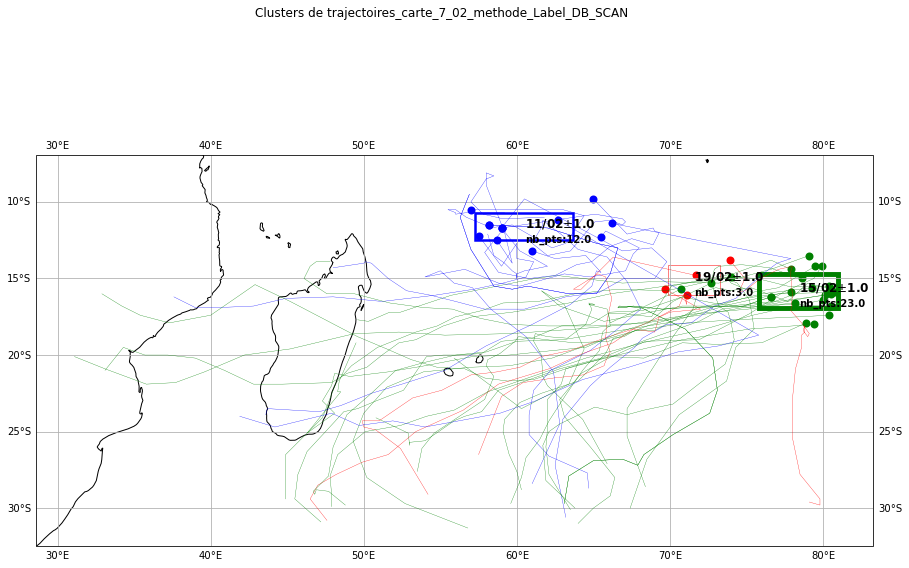

In [215]:
figure = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="50m", color="black", linewidth=1)
ax.gridlines(draw_labels=True)
plt.suptitle(f'Clusters de trajectoires_carte_{j}_0{m}_methode_{key}')

print(colored(f'Pour la colonne du {key}', attrs=['bold']))


df_ens_filtered_db_scan['Label_DB_SCAN'] = df_ens_filtered_db_scan['Label_DB_SCAN'].astype(int)
for i in range(0, len(df_ens_filtered_db_scan.index)):
    member_number = int(df_ens_filtered_db_scan.iloc[i,0])
    TC_number = int(df_ens_filtered_db_scan.iloc[i,1])
    os.chdir('C:/Users/etulyon1/Desktop/Stage M1/Data/francetransfert-1800090517/classification_TC_scenarii/' + run_dir + '/' + str(member_number).zfill(3))
    file_name = 'sin_TC_'  + str(member_number).zfill(2) + '_' + str(TC_number).zfill(2)
    f = open(file_name, "rt")
    LAT,LON, DUREE =extract_traj_from_TC_file(file_name, run_date)
    path = %pwd
    plt.plot(LON,LAT,color=cluster_color_list[df_ens_filtered_db_scan.iloc[i,-1]],linewidth=0.3)
    #affichage des points d'origine des trajectoire
    plt.scatter(LON[0],LAT[0], color=cluster_color_list[df_ens_filtered_db_scan.iloc[i,-1]], linewidth = 2)

#AFFICHAGE DES VALEURS DE LON, LAT ET START_DATE SUR LES CARTES AVEC LES ECART-TYPES
for day, month, lat, lon, pts, day_std, lat_std, lon_std in zip(jour_apparition, mois_apparition, latitude, longitude, nb_points, date_std, latitude_std, longitude_std):
    plt.text(lon,-lat, str(day)+'/0'+str(month)+'$\pm $'+str(day_std), fontsize = 'large', fontweight = 'semibold') #Affiche la date
    plt.text(lon,-lat-1, 'nb_pts:'+str(pts), fontsize = 'medium', fontweight = 'semibold') #affiche le nombre de points et permet de voir la probabilité d'occurence je crois
    rect = Rectangle( (round(lon-lon_std,1), round(-lat-lat_std,1)),2*round(lon_std,1), 2*round(lat_std,1), fill = False, lw = epaisseur(pts), color =  cluster_color_list[latitude.index(lat)])
    ax.add_patch(rect)

#On affiche
plt.show()

# Classification pour la trajectoire

## Regression polynomiale d'ordre 2

In [216]:
                        ############ON SELECTIONNE UNIQUEMENT LA CYCLOGENESE BATSIRAI #################
#Equation polynomiale de forme : ai + bi * t + ci * t**2 + ... + zi * t**n
# Ces fonctions vont permettre d'obtenir les regressions polynomiales d'ordre 2 
def latitude(t, a2, b2, c2): #Regression polynomiale pour la lontitude
    return a2 + b2 * t + c2 * t**2

def lontitude(t, a1, b1, c1): #Regression polynomiale pour la lontitude
    return a1 + b1 * t + c1 * t**2

## Affichage des différents sites de cyclogenèse

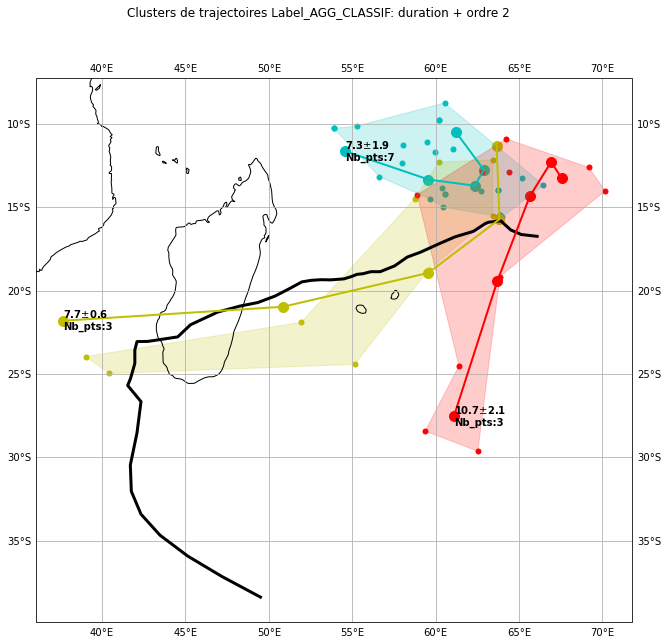

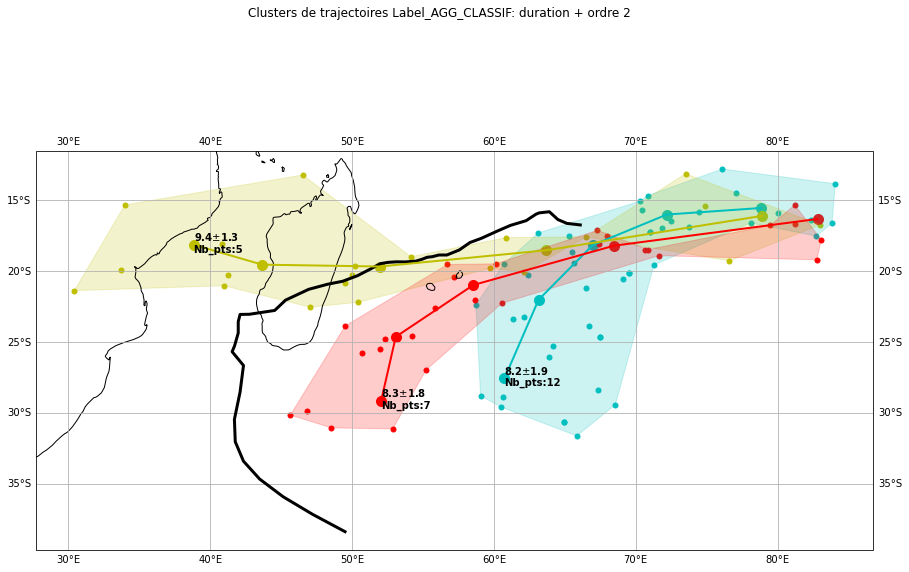

ValueError: A polygon or multi-polygon representation is required

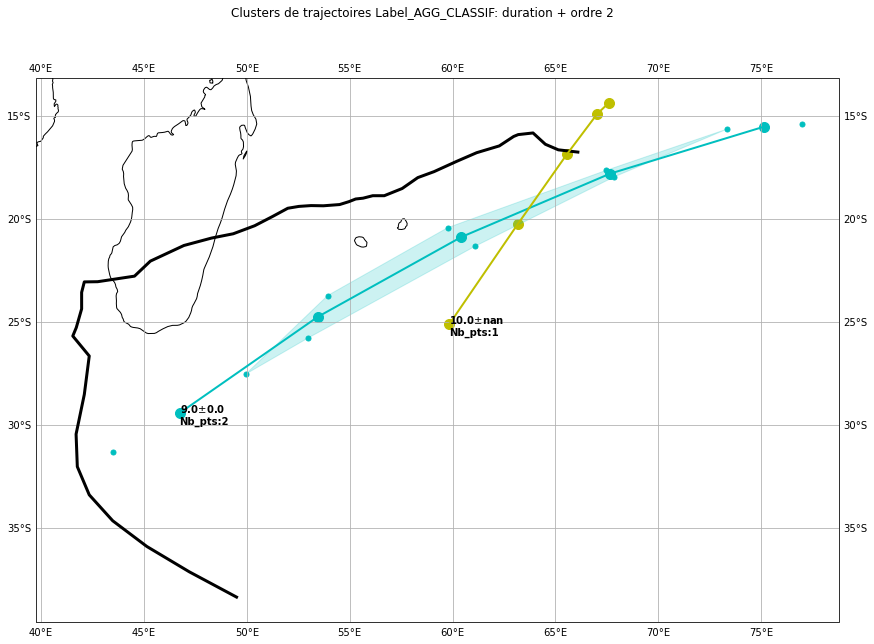

In [218]:
#On tente de boucler pour faire apparaîtres les clusters de trajectoires pour chaque cyclogenèse 
for val_label in  df_ens_filtered['Label_DB_SCAN'].value_counts().index.sort_values():
    
    #Permet de sélectionner uniquement un cluster de cyclogenèse
    df_ens_filtered_new = df_ens_filtered[df_ens_filtered['Label_DB_SCAN']== val_label ] 

    longi1, longi2, longi3, longi4, longi5 = [], [], [], [], []
    lati1, lati2, lati3, lati4, lati5 =[], [], [], [], []

    #Cette boucle permet d'enregistrer les valeurs de nos 10 features (5 pour la latitude et 5 pour la longitude)
    for i in range(0, len(df_ens_filtered_new.index)):
        member_number = int(df_ens_filtered_new.iloc[i,0])
        TC_number = int(df_ens_filtered_new.iloc[i,1])
        start_date = int(df_ens_filtered_new.iloc[i,2])
        os.chdir('C:/Users/etulyon1/Desktop/Stage M1/Data/francetransfert-1800090517/classification_TC_scenarii/' + run_dir + '/' + str(member_number).zfill(3))
        file_name = 'sin_TC_'  + str(member_number).zfill(2) + '_' + str(TC_number).zfill(2)
        f = open(file_name, "rt")

        LAT,LON, DUREE =extract_traj_from_TC_file(file_name, run_date)
        y, x, t = LAT,LON, DUREE
        tps = np.linspace(start_date, max(DUREE), 5)  #On divise la courbe en 5 avec le même pas de temps sur UNE trajectoire                   #PAS pour toutes les trajectoires
        #a1,b1,c1,a2,b2,c2 sont les coefficients des équations polynomiales
        popt_lon, _lon = curve_fit(lontitude, t, x)
        a1,b1,c1 = popt_lon
        popt_lat, _lat = curve_fit(latitude, t, y)
        a2,b2,c2 = popt_lat


        longi1.append(a1 + b1 * tps[0] + c1 * tps[0] **2) 
        longi2.append(a1 + b1 * tps[1] + c1 * tps[1] **2)
        longi3.append(a1 + b1 * tps[2] + c1 * tps[2] **2)
        longi4.append(a1 + b1 * tps[3] + c1 * tps[3] **2)
        longi5.append(a1 + b1 * tps[4] + c1 * tps[4] **2)

        lati1.append(a2 + b2 * tps[0] + c2 * tps[0] **2)
        lati2.append(a2 + b2 * tps[1] + c2 * tps[1] **2)
        lati3.append(a2 + b2 * tps[2] + c2 * tps[2] **2)
        lati4.append(a2 + b2 * tps[3] + c2 * tps[3] **2)
        lati5.append(a2 + b2 * tps[4] + c2 * tps[4] **2)

    #On implémente dans le DataFrame les valeurs de nos features
    df_ens_filtered_new_bis = df_ens_filtered_new.copy()#On crée une copie pour avoir accès l'ancier DataFrame si erreur
    df_ens_filtered_new_bis['LONGI1'] = longi1
    df_ens_filtered_new_bis['LONGI2'] = longi2
    df_ens_filtered_new_bis['LONGI3'] = longi3
    df_ens_filtered_new_bis['LONGI4'] = longi4
    df_ens_filtered_new_bis['LONGI5'] = longi5
    df_ens_filtered_new_bis['LATI1'] = lati1
    df_ens_filtered_new_bis['LATI2'] = lati2
    df_ens_filtered_new_bis['LATI3'] = lati3
    df_ens_filtered_new_bis['LATI4'] = lati4
    df_ens_filtered_new_bis['LATI5'] = lati5
    
    #La colonne DB_SCAN peut-être à présent enlever car le clustering sur la cyclogenèse est terminée
    df_ens_filtered_new_bis.drop(['Label_DB_SCAN'],axis=1,inplace=True)

                          ############CLUSTER SUR UNE CYCLO CONTENANT PLUSIEURS TRAJECTOIRES################# 

    #Voici la liste de nos 10 features    
    feature_list_ml = [ 'LONGI1','LONGI2', 'LONGI3', 'LONGI4', 'LONGI5', 'LATI1', 'LATI2', 'LATI3', 'LATI4', 'LATI5'] 
    n_features_ml = len(feature_list_ml)
    Y = df_ens_filtered_new_bis[feature_list_ml].to_numpy()
    Y= StandardScaler().fit_transform(Y)

    #Clustering grâce à la méthode Agglomerative Clustering
    #/!\/!\/!\/!\/!\Le choix du nombre de clusters dépend des situations. 
    #Une première execution permet ensuite d'ajuster pour la seconde/!\/!\/!\/!\/!\
    n_clusters = 3 
    linkage= "ward" #autres options possibles: "average", "complete", "single"
    clustering_traj = AgglomerativeClustering(linkage=linkage,n_clusters=n_clusters).fit(Y)

    #Pour enregistrer les valeurs des modèles     
    df_ens_filtered_new_bis['Label_AGG_CLASSIF'] = clustering_traj.labels_

    #Création d'un dictionnaire qui permet d'afficher les moyennes des features
    centroids_traj= dict()
    feature_list_traj = ['LONGI1','LONGI2', 'LONGI3', 'LONGI4', 'LONGI5', 'LATI1', 'LATI2', 'LATI3', 'LATI4', 'LATI5']
    n_features_traj = len(feature_list_traj)
    centroids_tmp = np.empty([n_clusters,n_features_traj])
    for cluster in range(0, n_clusters):
        df_cluster = df_ens_filtered_new_bis[df_ens_filtered_new_bis['Label_AGG_CLASSIF'] == cluster]
        #calcul des features du centroide du label
        for feature in range(0,n_features_traj):  
            centroids_tmp[cluster,feature] = df_cluster[feature_list_traj[feature]].mean()
    centroids_traj['Label_AGG_CLASSIF'] = centroids_tmp

                ##################ON CREE LA CARTE################

    figure = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    ax.gridlines(draw_labels=True)
    plt.suptitle(f"Clusters de trajectoires Label_AGG_CLASSIF: duration + ordre 2 ")
    cluster_color_list = ['c','y','r','m','m','y','b']


    ##################BOUCLE PERMETTANT DE TRACER LA TRAJECTOIRE MOYENNE DE TOUTES LES TRAJECTOIRES POUR CHAQUE CLUSTER#################
   
    for val_cluster in range(n_clusters):

        df_ens_filtered_no_hulled = df_ens_filtered_new_bis[df_ens_filtered_new_bis['Label_AGG_CLASSIF'] == val_cluster]
        longas = centroids_tmp[val_cluster][:5]
        latas = centroids_tmp[val_cluster][5:]
        plt.plot(longas, latas, color=cluster_color_list[val_cluster], linewidth = 2) #On plot les points de la droite moyenné
        plt.scatter(longas, latas, color=cluster_color_list[val_cluster], s = 100)
        moy = round(df_ens_filtered_no_hulled.TC_duration.mean(),1)
        std = round(df_ens_filtered_no_hulled.TC_duration.std(),1)
        plt.text(longas[-1], latas[-1] - 0.5, str(moy) +'$\pm $'+ str(std) + '\nNb_pts:'+str(len(df_ens_filtered_no_hulled)), fontsize = 'medium', fontweight = 'semibold')

        ##########CALCULE DES DISTANCES POUR ENLEVER LES POINTS ABERRANTS (TROP ÉLOIGNÉS DE LA TRAJECTOIRE MOYENNE)##############
        
        #Permet de prendre les coordonnées de la droite sous forme [ [x1,y1], [x2,y2], ..., [xn,yn]]
        coord_pt_droite = []
        for lon, lat in zip (longas, latas):
            coord_pt_droite.append([lon, lat])

        #On prend les coordonnées pour l'ensemble des trajectoires et pour chaque 'paquet' de point sous forme [ [x1,y1], [x2,y2], ..., [xn,yn]]
        coord_traj_pt1 = df_ens_filtered_no_hulled[['LONGI1', 'LATI1']].values 
        coord_traj_pt2 = df_ens_filtered_no_hulled[['LONGI2', 'LATI2']].values
        coord_traj_pt3 = df_ens_filtered_no_hulled[['LONGI3', 'LATI3']].values
        coord_traj_pt4 = df_ens_filtered_no_hulled[['LONGI4', 'LATI4']].values
        coord_traj_pt5 = df_ens_filtered_no_hulled[['LONGI5', 'LATI5']].values

        #On calcule la distance entre chaque point des différentes trajectoires avec les points de la droite
        dist1, dist2, dist3, dist4, dist5 = [],[],[],[],[]

        for val_pt_traj in range(len(coord_traj_pt1)) : #On calcule les distances pour chaque pts traj et chaque pt de la droite
            dist1.append(distance(coord_pt_droite[0], coord_traj_pt1[val_pt_traj])) #Distance entre le pt 1 (0) et les pts des trajectoires autour de lui
            dist2.append(distance(coord_pt_droite[1], coord_traj_pt2[val_pt_traj]))
            dist3.append(distance(coord_pt_droite[2], coord_traj_pt3[val_pt_traj]))
            dist4.append(distance(coord_pt_droite[3], coord_traj_pt4[val_pt_traj]))
            dist5.append(distance(coord_pt_droite[4], coord_traj_pt5[val_pt_traj]))

        #On met les résultats dans le dataFrame
        df_ens_filtered_no_hulled_dist = df_ens_filtered_no_hulled.copy()
        df_ens_filtered_no_hulled_dist['Distance_1'] = dist1  
        df_ens_filtered_no_hulled_dist['Distance_2'] = dist2
        df_ens_filtered_no_hulled_dist['Distance_3'] = dist3
        df_ens_filtered_no_hulled_dist['Distance_4'] = dist4
        df_ens_filtered_no_hulled_dist['Distance_5'] = dist5


        #On filtre par rapport aux distances (on enlève les pts trop loin)
        coeff = 1.4
        df_filtered_dist1 = df_ens_filtered_no_hulled_dist[df_ens_filtered_no_hulled_dist['Distance_1'] < coeff*df_ens_filtered_no_hulled_dist['Distance_1'].mean()]
        df_filtered_dist2 = df_ens_filtered_no_hulled_dist[df_ens_filtered_no_hulled_dist['Distance_2'] < coeff*df_ens_filtered_no_hulled_dist['Distance_2'].mean()] 
        df_filtered_dist3 = df_ens_filtered_no_hulled_dist[df_ens_filtered_no_hulled_dist['Distance_3'] < coeff*df_ens_filtered_no_hulled_dist['Distance_3'].mean()] 
        df_filtered_dist4 = df_ens_filtered_no_hulled_dist[df_ens_filtered_no_hulled_dist['Distance_4'] < coeff*df_ens_filtered_no_hulled_dist['Distance_4'].mean()] 
        df_filtered_dist5 = df_ens_filtered_no_hulled_dist[df_ens_filtered_no_hulled_dist['Distance_5'] < coeff*df_ens_filtered_no_hulled_dist['Distance_5'].mean()] 


        #Permet de concaténer les différents points de longitude filtrés cette fois-ci
        l1_filtered = df_filtered_dist1['LONGI1'].to_numpy()
        l2_filtered = df_filtered_dist2['LONGI2'].to_numpy()
        l3_filtered = df_filtered_dist3['LONGI3'].to_numpy()
        l4_filtered = df_filtered_dist4['LONGI4'].to_numpy()
        l5_filtered = df_filtered_dist5['LONGI5'].to_numpy()
        longituda_filtered = np.concatenate((l1_filtered, l2_filtered, l3_filtered, l4_filtered, l5_filtered))
        #Permet de concaténer les différents points de latitude filtrés cette fois-ci
        la1_filtered = df_filtered_dist1['LATI1'].to_numpy()
        la2_filtered = df_filtered_dist2['LATI2'].to_numpy()
        la3_filtered = df_filtered_dist3['LATI3'].to_numpy()
        la4_filtered = df_filtered_dist4['LATI4'].to_numpy()
        la5_filtered = df_filtered_dist5['LATI5'].to_numpy()
        latituda_filtered = np.concatenate((la1_filtered, la2_filtered, la3_filtered, la4_filtered, la5_filtered))

        #On crée un nouveau DataFrame qui permet de tracer l'enveloppe après le filtrage 
        data_filtered = { 'Longitude_filtered': longituda_filtered, 'Latitude_filtered': latituda_filtered}
        df_ens_filtered_hull_filtered = pd.DataFrame(data_filtered)
        #Création de matrice avec les coordonnées filtrées
        coord_filtered = df_ens_filtered_hull_filtered.values
        
        
        ##################ON TRACE LES ENVELOPPES DES MOYENNES################
        import alphashape
        from descartes import PolygonPatch

        alpha = 0.1 #Meilleur valeur je pense
        alphashape = alphashape.alphashape(coord_filtered, alpha)
        ax.scatter(coord_filtered[:,0], coord_filtered[:,1], color = cluster_color_list[val_cluster], s = 25)
        ax.add_patch(PolygonPatch(alphashape, alpha=0.2, color = cluster_color_list[val_cluster])) #Ce alpha gère la "densité" de la couleur
        
        ##################CHOISIR LA TRAJECTOIRE VRAIE QUE L'ON SOUHAITE TRACER################
        #Remplacer Batsirai pour le nom du cyclone dont on souhaite voir la vraie trajectoire
        if val_cluster == 0 :
            plt.plot(traj_Batsirai.lon, traj_Batsirai.lat, color = 'black', lw = 3)
            
    ##################ON AFFICHE################
    plt.show()